<a href="https://colab.research.google.com/github/Datanerd97/PyTorch/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ab7087a2690>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

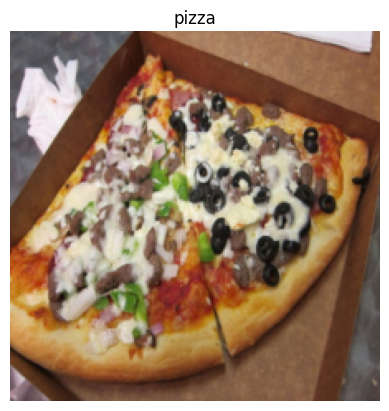

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [10]:
# TODO: your code

from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


[PosixPath('data/pizza_steak_sushi/test/sushi/2903125.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2352914.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/124279.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1683426.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3834718.jpg')]

In [11]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict


# 1. Create a function to return a list of dictionaries with sample, truth labels, predictions , prediction probability and prediction time

def pred_and_store(paths: List[pathlib.Path], # A List of Paths
                   model: torch.nn.Module, # Trained PyTorch Model
                   transform: torchvision.transforms, # Series of Transforms
                   class_names: List[str], # list of target class names
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]: # Target device

  # 2. Create an empty list to store prediction dictionaries
  pred_list = []

  # 3. Loop thorugh target paths
  for path in tqdm(paths):

    # 4. Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open Image Path
    img = Image.open(path)

    # 8. Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # Prepare model for inference by sending it to target device and turning on eval() model
    model.to(device)
    model.eval()

    # 10. Get prediction probability, prediction label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit,dim = 1)
      pred_label = torch.argmax(pred_prob, dim = 1)
      pred_class = class_names[pred_label.cpu()]

      # 11. Make sure things in the dictionary are on the CPU
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End The Timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)


    # 13. Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # 14. Add the dictionary to the list of preds
    pred_list.append(pred_dict)


  # 15. Return list of prediction dictionaries
  return pred_list


#### Prepare and Testing EffNetB2 Feature Extractor

In [12]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms


In [13]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3,
                                 seed = 42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 124MB/s]


We want to transform the data we load to be transformed into the data that it was trained on.

In [14]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir = test_dir,
                                                                                                 transform = effnetb2_transforms,
                                                                                                 batch_size = 32)

In [15]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


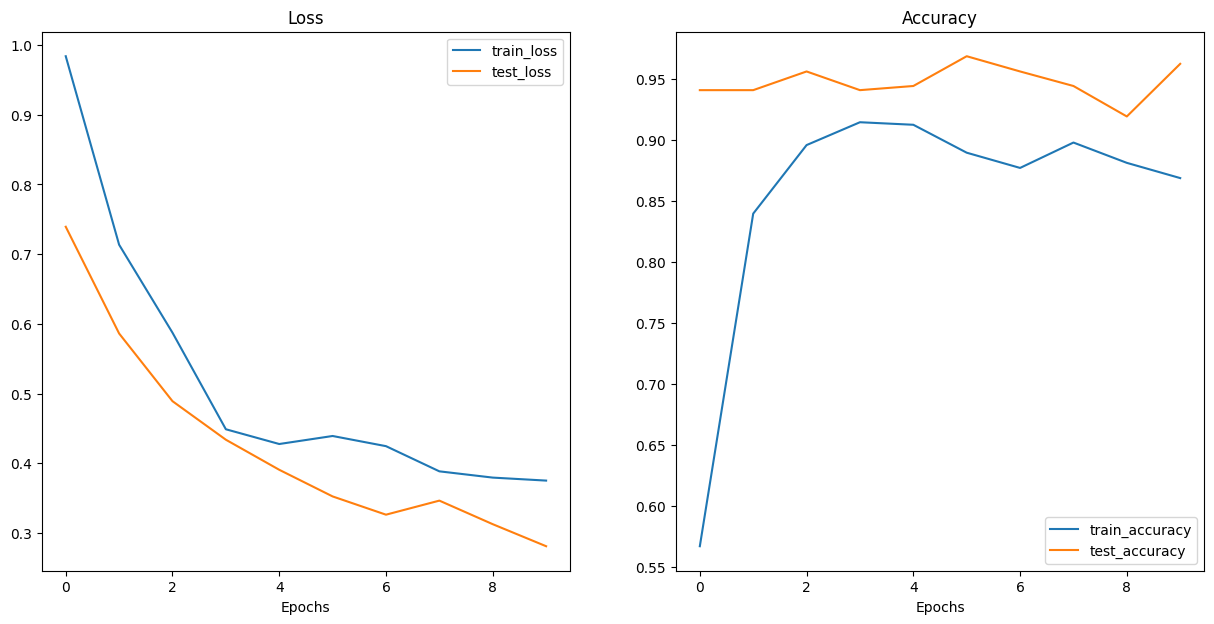

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

#### Create A VIT Feature Extractor

In [23]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [24]:
ViT, ViT_transforms = create_vit_model(num_classes = 3,
                                 seed = 42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 193MB/s]


We want to transform the data into the data that the model was trained on.

In [26]:
# Create A DataLoader

from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir = test_dir,
                                                                                                 transform = ViT_transforms,
                                                                                                 batch_size = 32)

In [27]:
from going_modular.going_modular import engine

# Setup Optimizer
optimizer = torch.optim.Adam(params = ViT.parameters(),
                             lr = 1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seed for repoduciblity and train the model

vit_results = engine.train(model = ViT,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           epochs = 10,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5947 | train_acc: 0.8063 | test_loss: 0.2576 | test_acc: 0.9443
Epoch: 2 | train_loss: 0.2045 | train_acc: 0.9417 | test_loss: 0.1342 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.1816 | train_acc: 0.9229 | test_loss: 0.1066 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.1603 | train_acc: 0.9625 | test_loss: 0.1038 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1067 | train_acc: 0.9708 | test_loss: 0.0974 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0914 | train_acc: 0.9750 | test_loss: 0.0854 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.1316 | train_acc: 0.9479 | test_loss: 0.0801 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0738 | train_acc: 0.9854 | test_loss: 0.0851 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0802 | train_acc: 0.9917 | test_loss: 0.0786 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.0579 | train_acc: 0.9917 | test_loss: 0.0712 | test_acc: 0.9659


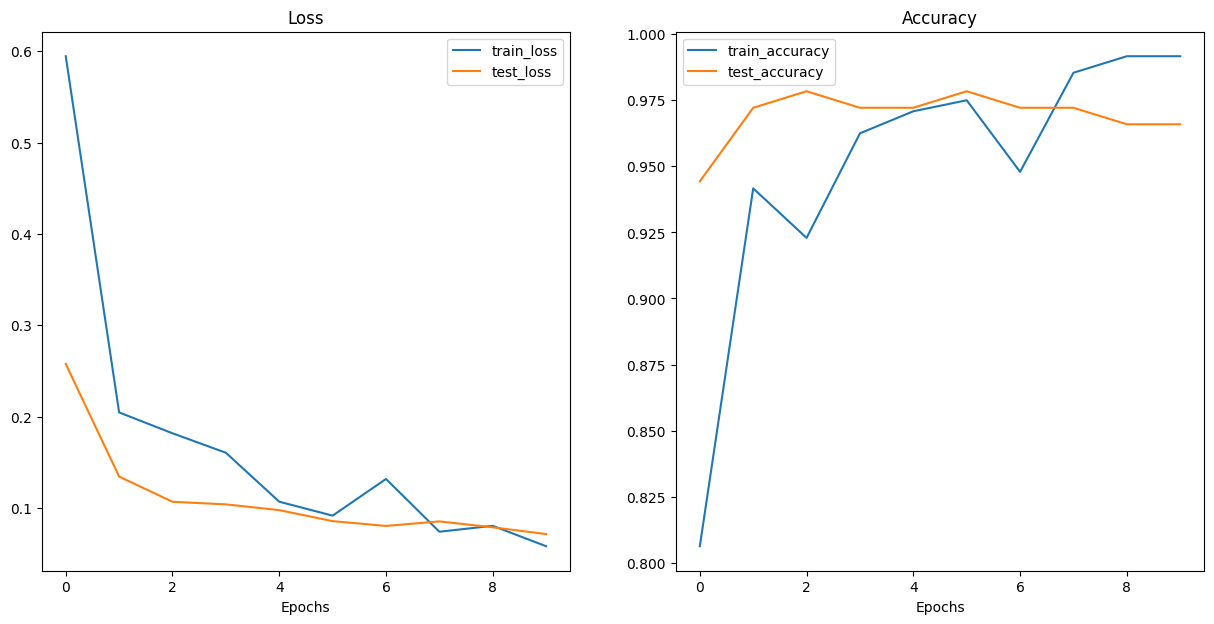

In [28]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### Compare Predictions on GPU vs CPU

In [31]:
vit_cpu = pred_and_store(paths = test_data_paths,
                         model = ViT,
                         class_names = class_names,
                         transform = ViT_transforms,
                         device = "cpu")

effnetb2_cpu = pred_and_store(paths = test_data_paths,
                              model = effnetb2,
                              class_names = class_names,
                              transform = effnetb2_transforms,
                              device = "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [32]:
vit_gpu = pred_and_store(paths = test_data_paths,
                         model = ViT,
                         class_names = class_names,
                         transform = ViT_transforms,
                         device = "cuda")

effnetb2_gpu = pred_and_store(paths = test_data_paths,
                              model = effnetb2,
                              class_names = class_names,
                              transform = effnetb2_transforms,
                              device = "cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

### Print Out The Results..

In [43]:
import pandas as pd
def avg_time_for_pred(input):
  df = pd.DataFrame(input)
  return df.time_for_pred.mean()


effnetb2_pred_time = avg_time_for_pred(effnetb2_cpu)
effnetb2_pred_time_gpu = avg_time_for_pred(effnetb2_gpu)
vit_pred_time = avg_time_for_pred(vit_cpu)
vit_pred_time_gpu = avg_time_for_pred(vit_gpu)


pred_times = {"effnetb2_cpu": effnetb2_pred_time,
              "effnetb2_gpu": effnetb2_pred_time_gpu,
              "vit_cpu": vit_pred_time,
              "vit_gpu" : vit_pred_time_gpu
}

pred_df = pd.DataFrame(pred_times, index = [0])
pred_df

effnetb2_cpu  effnetb2_gpu   vit_cpu   vit_gpu
0      0.099854      0.024481  0.400451  0.021567

It looks like the predictions on the GPU are much faster than the CPU overall. And it looks like the vit model is faster on the gpu than effnetb2 on the GPU

But we see that on the cpu effnetb2 is better on the cpu than vit on the cpu

If we had acess to a gpu in deployment, a ViT Model would be better due to have lower latency as well as better performance.

So effnetb2 on the cpu has lower latency (prediction time) as well as better performance.

But if we are focused on deploying to CPU, EffnetB2 wins because of good performance + faster inference time.

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [53]:
# Create ViT model capable of fitting to 101 classes for Food101
vit_food101, vit_transforms = create_vit_model(num_classes=101)

Because of the large amount of data, going to use data augmentation to (hopefully) prevents overfitting

In [54]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

In [55]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [56]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [57]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [58]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [59]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2  # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)


len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [61]:
### Train ViT Feature Extractor on 20% of Food101 data

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)

# Optimizer
optimizer = torch.optim.Adam(params = vit_food101.parameters(),
                             lr = 1e-3)

# Train the model
set_seeds()
vit_food101_20_percent_results = engine.train(model = vit_food101,
                                              train_dataloader = train_dataloader_food101_20_percent,
                                              test_dataloader = test_dataloader_food101_20_percent,
                                              epochs = 5,
                                              optimizer = optimizer,
                                              loss_fn = loss_fn,
                                              device = device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


In [17]:
# TODO: your code


## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [63]:
# TODO: your code # Create batch size of 1 (predict on 1 image at a time..)
from torch.utils.data import DataLoader # Import DataLoader
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                                                  batch_size = 1,
                                                  shuffle = False,
                                                  num_workers = NUM_WORKERS)

# Prepare model (do outside the loop)
vit_food101_20_percent = vit_food101.to(device)
vit_food101_20_percent.eval()


# Loop thorugh test dataloader with batch size 1 and make predictions on each image
# Store predictions and truth values to a dictionary and then append dictionary to list
vit_food101_pred_list = []
for X,y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device),  y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)


  0%|          | 0/5050 [00:00<?, ?it/s]

In [64]:
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [66]:
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create A column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class names columns (e.g pred_label = 72 -> pred_class = "pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

pred_prob  pred_label  label  is_correct            pred_class  \
0   0.7962381          72     72        True              pancakes   
1   0.6283233          57     57        True                hummus   
2  0.19211605          80     80        True  pulled_pork_sandwich   
3  0.57428443          51     51        True             guacamole   
4   0.8206848           1      1        True        baby_back_ribs   

            label_class  
0              pancakes  
1                hummus  
2  pulled_pork_sandwich  
3             guacamole  
4        baby_back_ribs

Check 2 hours within the video for an explanation?

In [77]:
# Get top ten samples that are "most wrong", e.g highest pred_prob but wrong predictions
pred_df_20_percent[pred_df_20_percent['is_correct'] == False].sort_values('pred_prob',ascending = False)

pred_prob  pred_label  label  is_correct         pred_class  \
3107    0.9834614          52     32       False              gyoza   
1306   0.94412065          71     44       False             paella   
2848    0.9294365          41      8       False  french_onion_soup   
708    0.90649515           9     12       False  breakfast_burrito   
1726    0.8809202          68     43       False        onion_rings   
...           ...         ...    ...         ...                ...   
3379   0.07714542          93      6       False              steak   
423    0.07626273          87     57       False           scallops   
2038   0.07548251         100      0       False            waffles   
1017  0.067695074          87     28       False           scallops   
3926  0.053655967           0     42       False          apple_pie   

         label_class  
3107       dumplings  
1306      fried_rice  
2848   bread_pudding  
708          cannoli  
1726  fried_calamari  
...              ...  
3379        beignets  
423           hummus  
2038       apple_pie  
1017   croque_madame  
3926    french_toast  

[1475 rows x 6 columns]

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [68]:
# TODO: your code
len(test_data)

25250

In [71]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader
# Create batch size of 1

test_dataloader_food101_all_data_batch_size_1 = DataLoader(test_data,
                                                  batch_size = 1,
                                                  shuffle = False,
                                                  num_workers = NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

25250

In [72]:
# Prepare model
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop Thorugh Test Dataloader with batch size 1 and make predictions on each image
# Store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X,y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim = 1)
    pred_labels = torch.argmax(pred_probs,dim = 1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)


  0%|          | 0/25250 [00:00<?, ?it/s]

In [82]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

is_correct
True     17849
False     7401
Name: count, dtype: int64

In [84]:
## Calculate accuracy across Food101 all test value is 0 for correct ones.
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts().iloc[0] / len(food101_all_test_data_df)}")

Accuracy of ViT model on all of Food101 test data: 0.7068910891089109


## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

I've found this recent paper on Paperswithcode.org that talks about a second-order like optimizer with adaptive gradient scaling for Deep- Learning.

Link: https://arxiv.org/pdf/2410.05871v2

This paper uses pre-trained VGG11 and ResNet 18 models with the INNAProp optimizer and comparing them against AdamW baselines.

In [20]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?
See the deployed FoodVision Mini model here: https://huggingface.co/spaces/mrdbourke/foodvision_mini

Problems:

* Someone uploads a photo that isn't food...
Potential solution: train two models, one that classifies images into "food" or "not food" and if an image is found to be "not food" display a message, if it is found to be "food", classify it into a certain class.
* Someone uploads a photo of food but our model doesn't have the capacity to classify that certain class...
Potential solutions:
Get more data for unknown classes (upgrade the model).
Ask someone if the prediction is right/wrong, if it's wrong, track it to a database and update later (active learning - https://en.wikipedia.org/wiki/Active_learning_(machine_learning)).
* The image quality is poor (food in top left of image rather than center)
Potential solution: add guidelines to the camera app to hint at taking a photo with the subject in the middle
* Multiple foods in one shot
Potential solution:
Return multiple classification results (e.g. the top 5 classification predication probabilities)
Object detection (detect each different food in an image and individually classify them)

In [21]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [22]:
# TODO: your code